# Harris Corner Detection

## Pendahuluan

### Import library yang dibutuhkan

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

from scipy import signal as sig
from scipy import ndimage as ndi

### Fungsi Penting

In [8]:
def show_image(title, img) :
    plt.figure(figsize= (20,20))
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()


### Baca dan Tampilkan Gambar

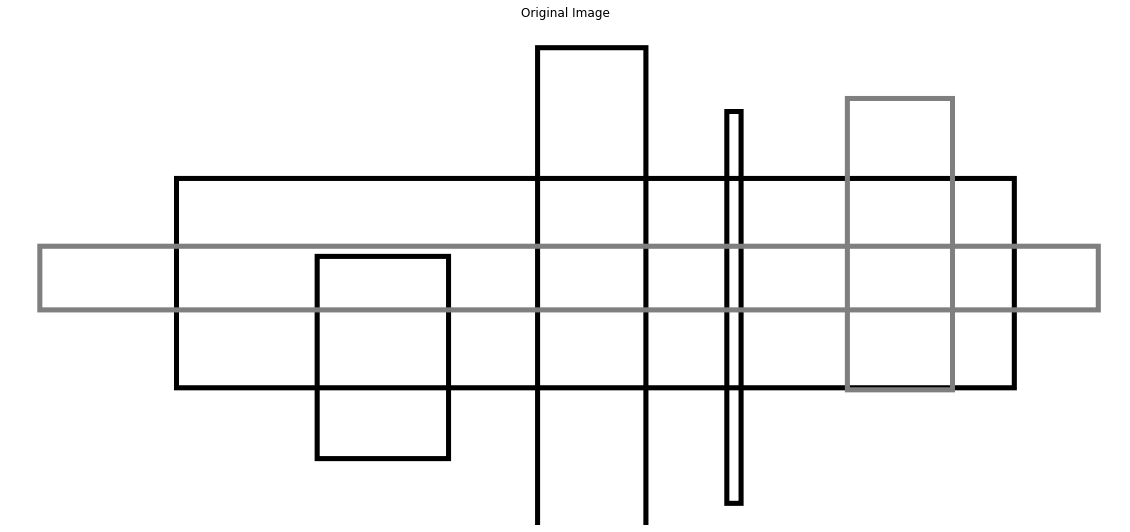

In [12]:
from skimage.io import imread
from skimage.color import rgb2gray

img = imread('square.png')
imggray = rgb2gray(img)

show_image("Original Image", img)

## Harris Corner Detection

Harris Corner Detection mendeteksi titik pojok dari suatu gambar dengan pendekatan matematika.

Kita dapat mengenali titik pohok tersebut dengan melihat nilai intensitas dalam suatu window kecil.

Dengan melakukan shifting pada window ke segala arah, kita dapat melakukan klasifikasi mana yang merupakan flat region, edge, atau bahkan korner

Korner dapat terdeteksi apabila pada saat melakukan shifting pada window terdapat perubahan intensitas yang signifikan di segala arah.

![Classification](classification.png)

Perubahan intensitas dengan pergeseran $(u,v)$ dapat dituliskan dalam persamaan

$$
E(u,v) = \sum_{x,y}w(x,y)[I(x+u, y+v)- I(x,y)]^2
$$

Dengan $w(x,y)$ adalah window function. Window function bisa dalam gaussian atau dalam binary (1 dalam window, dan 0 di outside)

Dengan menggunakan deret taylor untuk fungsi 2D, kita dapat peroleh bahwa 
$$f(x+u, u+v) \approx f(x,y) + uf_x(x,y)+ v f_y(x,y)$$

Sehingga persamaan di atas dapat ditulis ulang menjadi

$$
E(u,v) = \sum_{x,y}[I(x+u, y+v)- I(x,y)]^2 \\
E(u,v) \approx \sum_{x,y}[I(x,y) + uI_x + vI_y - I(x,y)]^2 \\
E(u,v) \approx \sum u^2I_x^2 + 2uvI_xI_y + v^2 I^2_y \\
E(u,v) \approx  \sum \begin{bmatrix} u & v\end{bmatrix}  \begin{bmatrix} I_x^2 & I_x I_y \\ I_x I_y & I_y^2  \end{bmatrix} \begin{bmatrix} u\\v \end{bmatrix} \\
E(u,v) \approx  \begin{bmatrix} u & v\end{bmatrix}  (\sum \begin{bmatrix} I_x^2 & I_x I_y \\ I_x I_y & I_y^2  \end{bmatrix})  \begin{bmatrix} u\\v \end{bmatrix} 
$$

Untuk pergeseran kecil, dapat diaproksimasikan sebagai
$$E(u,v) \approx \begin{bmatrix} u & v\end{bmatrix}  M \begin{bmatrix} u\\v \end{bmatrix} 
$$
Di mana $M$ adalah matriks $2 \times 2$ yang dihitung dari turunan gambar 

$$
M = \sum_{x,y}[w(x,y)]\begin{bmatrix} I_x^2 & I_x I_y \\ I_x I_y & I_y^2  \end{bmatrix} 
$$ 

Setelah itu, kita menghitung corner response measure yang dirumuskan sebagai 

$$
R = \det{M} - k (trace(M))^2\\
\det M = \lambda_1 \lambda_2\\
trace(M) = \lambda_1+\lambda_2
$$
Dengan $k$ adalah konstanta di mana $k=0.04-0.06$

Nilai $R$ akan digunakan untuk klasifikasi <br>
$R$ akan besar untuk sebuah corner <br>
$R$ negatif dengan magn9itude yang besar untuk edge<br>
$|R|$ kecil untuk flat region

## Algortima Harris Corner

1. Compute Gaussian derivatives at each pixel
2. Compute second moment matrix M in a Gaussian window around each pixel
3. Compute corner response function R
4. Threshold R
5. Find local maxima of response function (non-maximum suppression)

### Step 1 - Compute Gaussian derivatives at each pixel

In [13]:
from scipy import signal as sig
import numpy as np

def gradient(img):

    '''
    Fungsi untuk menghitung gradient (Gaussian Derivatives) dengan operator Sobel.
    '''
    
    Mx = np.array([
            [-1, 0, 1],
            [-2, 0, 2],[
            -1, 0, 1]])
    
    My = Mx.T
    
    f_x, f_y = sig.convolve2d(img, Mx, mode='same'), sig.convolve2d(img, My, mode='same')
    
    magnitude = np.sqrt(f_x ** 2 + f_y ** 2) 
    magnitude = magnitude / magnitude.max() * 255 # Melakukan pengskalaan agar terbatas sampai 255
    direction = np.arctan2(f_y, f_x)
    
    return f_x, f_y, magnitude, direction


# Hitung untuk turunan pertama terhadap sumbu x dan sumbu
Ix, Iy, magnitude, direction = gradient(imggray)


### Step 2 - Compute second moment matrix M in a Gaussian window around each pixel

Dengan menggunakan fungsi pada scipy.ndimages, hitung turunan kedua (Second Moment) menggunakan Gaussian Window dengan dipilih $\sigma =1 $. 
Matriks $M$ yang dimaksud adalah
$$
M = \begin{bmatrix} I_x^2 & I_x I_y \\ I_x I_y & I_y^2  \end{bmatrix} 
$$

In [14]:
Ixx = ndi.gaussian_filter(Ix**2, sigma=1) # Turunan Ix terhadap x
Ixy = ndi.gaussian_filter(Ix*Iy, sigma=1) # Turunan Ix terhadap y
Iyy = ndi.gaussian_filter(Iy**2, sigma=1) # Turunan Iy terhadap y

### Step 3 - Compute corner response function R

Menghitung Corner Response R, di mana 

$$
R = \det{M} - k (trace(M))^2\\
\det M = I_{xx}  I_{yy} - I_{xy}^2\\
trace(M) = I_{xx} + I_{yy}
$$
Dengan $k$ adalah konstanta di mana $k=0.04-0.06$

Nilai $R$ akan digunakan untuk klasifikasi <br>
$R$ akan besar untuk sebuah corner <br>
$R$ negatif dengan magn9itude yang besar untuk edge<br>
$|R|$ kecil untuk flat region

In [15]:
# Dipilih k = 0.05
k = 0.05

# Hitung det(M)
det_M = Ixx * Iyy - Ixy ** 2

# hitung Trace(M)
trace_M = Ixx + Iyy

# hitung R
R = det_M - k * (trace_M) ** 2

### Step 4 - Thresholding

Memilih nilai threshold untuk memilih mana batas yang bisa dikatakan sebagai corner

In [17]:
img_with_corners = np.copy(img)
img_with_corners = cv2.dilate(img_with_corners, None)

threshold = 0.01 * img_with_corners.max()

print(f"Threshold : {threshold}")

Threshold : 2.5500000000000003


### Step 5 - Find local maxima of response function (non-maximum suppression)

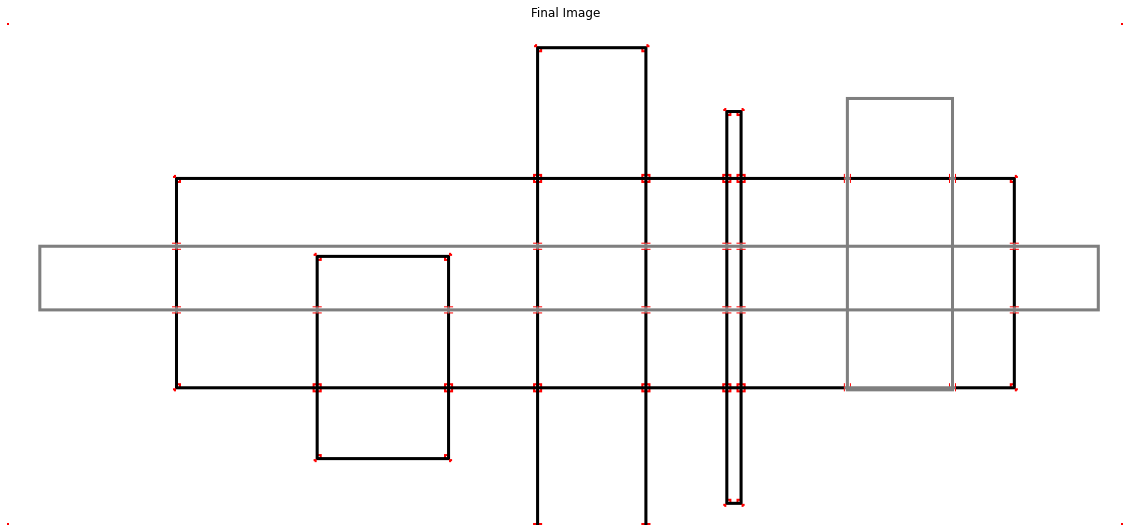

In [18]:
# Melakukan looping untuk menandai setiap corner (corner : R > threshold)
for y, res in enumerate(R):
    for x, r in enumerate(res):
        if r > threshold: # Supress semua corner yang di bawah nilai threshold. (Non Maxima Supression)
            img_with_corners[y, x] = [255,0,0] # Jika dia adalah thershold, beri warna merah

show_image('Final Image', img_with_corners)

In [17]:
import  cv2
import numpy as np

from scipy import signal as sig

mat = np.array(
    [
        [25,22,20,17],
        [25,28,19,17],
        [20,19,19,17],
        [15,15,15,15]
    ]
)

scale_1 = 1
scale_2 = 2
scale_3 = 3
scale_4 = 4
scale_5 = 5

dog_1 = mat - scale_1 * mat

print(dog_1)

[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
